In [1]:
from __future__ import annotations
from typing import Any

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

# Render plots as SVG
%config InlineBackend.figure_format = 'svg'

In [2]:
df = (pd
    .read_csv(
        'data/crosswriters_with_ents.csv', 
        encoding='utf-8', 
        usecols=['text', 'title', 'author', 'author_gender', 'reader_age_group']
    )
    .astype({
        'author': 'category', 
        'title': 'category', 
        'author_gender': 'category', 
        'reader_age_group': 'category'
    })
)
df.sample(10)

,text,author,title,author_gender,reader_age_group
2431,frozen rock-glass to their left. “walk between...,Neil Gaiman,American Gods,M,adult
5881,can’t get out . . . i’m all alone . . . ’ ‘yea...,J.K. Rowling,Lethal White,F,adult
6371,again. daisy dovetail for some months after mr...,J.K. Rowling,The Ickabog,F,child
1060,their heads off. everything made us laugh. my ...,Anne Fine,Blood Family,F,child
5565,"look at mrs weasley, who was trying to persuad...",J.K. Rowling,Harry Potter and the Order of the Phoenix,F,child
1130,the hard little wooden chair and followed him ...,Anne Fine,Eating Things on Sticks,F,child
4846,free rein at last.’ lockhart gazed desperately...,J.K. Rowling,Harry Potter and the Chamber of Secrets,F,child
3884,"speech was not slurred, and his movements were...",Philip Pullman,The Ruby in the Smoke,M,child
4573,and the girl stood frozen. the crack of the sl...,Philip Pullman,The White Mercedes,M,child
482,"rung to rung, just like they were climbing, bu...",David Almond,The Boy Who Climbed Into the Moon,M,child


## SVM: Child vs Adult 

### All authors

In [3]:
print("Before:", df['reader_age_group'].value_counts(), sep="\n", end="\n\n")

enc = LabelEncoder()
enc.fit(df['reader_age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['reader_age_group'] = enc.transform(df['reader_age_group'])

print("After:", df['reader_age_group'].value_counts(), sep="\n")
encoded_labels

Before:
child    4412
adult    2457
Name: reader_age_group, dtype: int64

After:
1    4412
0    2457
Name: reader_age_group, dtype: int64


{'adult': 0, 'child': 1}

In [4]:
X = df['text']
y = df['reader_age_group']
groups = df['title']

gss_cv = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=97)
train_idx, test_idx = next(gss_cv.split(X, y, groups))  # GSS is a generator, so we need to call next()

X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5400,), (1469,), (5400,), (1469,))

In [5]:
y_test.value_counts()

1    1010
0     459
Name: reader_age_group, dtype: int64

Let's check whether there is leakage in `y_test` after Leaving-One-Text-Out.

To do this, we:

1. Get the initial DataFrame and a subset thereof with only the `y_test` indices grouped by `title`.
2. Convert the two groups into dictionaries.
3. Compare the two dictionaries using our `compare_dict_values()` function.

> **Note: This function was first impemented for another reason (see comment below), but I extended it by adding the `unchanged` argument to return only the items that are exactly the same between the dicts.**

In [6]:
# Problem: `GridSearchCV.best_estimator_.get_params()` doesn't return *just* the parameters that changed.
# As a result, it's hard to know which one(s) have overriden the defaults.
# So, I made a function (moved it above due to earlier assignment) that returns the parameters that changed - inspired by `set.difference()`.
# This function came in handy (added `unchanged`) after Prof. Kestemont's feedback to check whether there is leakage in `y_test`.
# I also made another one that looks at the keys and returns the ones that their values are different.

def compare_dict_values(d1: dict, d2: dict, unchanged: bool = False) -> dict:
    condition = lambda x, y: y != d1[x] if not unchanged else y == d1[x]
    return {k: v for k, v in d2.items() if condition(k, v)}

def compare_dict_keys(d1: dict, d2: dict) -> dict:
    return {k: v for k, v in d2.items() if k not in d1}

In [7]:
titles_dict = df.groupby('title').size().to_dict()
y_test_dict = df.iloc[y_test.index].groupby('title').size().to_dict()

compare_dict_values(titles_dict, y_test_dict, unchanged=True)

{'A Pack of Liars': 28,
 'American Gods': 182,
 "Bill's New Frock": 10,
 'Clockwork': 12,
 'Coraline': 30,
 'Count Karlstein': 51,
 'Crummy Mummy and Me': 19,
 'Harry Potter and the Chamber of Secrets': 89,
 'How Brave Is That?': 3,
 'How To Write Really Badly': 12,
 'Ivan the Terrible': 11,
 'Jackdaw Summer': 36,
 'Jamie and Angus Together': 9,
 'La Belle Sauvage': 128,
 'Lethal White': 207,
 'M is for Magic': 47,
 "My Dad's a Birdman": 12,
 'On Planet Fruitcake': 8,
 'Scaredy-Cat': 3,
 'Skellig': 31,
 'The Book of the Banshee': 38,
 'The Fire Eaters': 37,
 'The Same Old Story Every Year': 3,
 'The Scarecrow and his Servant': 37,
 'The Secret Commonwealth': 185,
 'The Shadow in the North': 83,
 'The Stone Menagerie': 25,
 'The Tightrope Walkers': 70,
 'The Worst Child I Ever Had': 2,
 "Thunderbolt's Waxwork": 24,
 'Trouble in Toadpool': 36,
 'Under the Bed': 1}

In [9]:
vect = TfidfVectorizer() # Pre-NER run
svm  = LinearSVC()
pipe = make_pipeline(vect, svm)

pprint(pipe.get_params(), sort_dicts=False)

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()), ('linearsvc', LinearSVC())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'linearsvc': LinearSVC(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': <class 'numpy.float64'>,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocabulary': 

In [10]:
param_grid = {
    'linearsvc__class_weight': ['balanced', {1: 0.33, 0: 0.67}],  # the child class has almost twice as many data as the adult class
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__max_df': [0.25, 0.5, 0.75],
    'tfidfvectorizer__lowercase': [False]  # already lowercased
}

In [11]:
gs = GridSearchCV(
    pipe,
    param_grid,
    cv=gss_cv,
    scoring=('f1_macro', 'accuracy'),
    n_jobs=-1,  # for some weird reason, setting `n_jobs` != 1 causes `verbose` not to work in VS Code notebooks...
    refit='f1_macro',
    verbose=5
)
gs.fit(X_train, y_train, groups=groups[train_idx])

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=GroupShuffleSplit(n_splits=10, random_state=97, test_size=0.2,
         train_size=None),
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('linearsvc', LinearSVC())]),
             n_jobs=-1,
             param_grid={'linearsvc__class_weight': ['balanced',
                                                     {0: 0.67, 1: 0.33}],
                         'tfidfvectorizer__lowercase': [False],
                         'tfidfvectorizer__max_df': [0.25, 0.5, 0.75],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             refit='f1_macro', scoring=('f1_macro', 'accuracy'), verbose=5)

In [12]:
print(f"Best score: {gs.best_score_:.3f}", end="\n\n")

default_params = pipe.get_params()
best_est_params = gs.best_estimator_.get_params()
compare_dict_values(default_params, best_est_params)

Best score: 0.705



{'steps': [('tfidfvectorizer',
   TfidfVectorizer(lowercase=False, max_df=0.5, ngram_range=(1, 2))),
  ('linearsvc', LinearSVC(class_weight={0: 0.67, 1: 0.33}))],
 'tfidfvectorizer': TfidfVectorizer(lowercase=False, max_df=0.5, ngram_range=(1, 2)),
 'linearsvc': LinearSVC(class_weight={0: 0.67, 1: 0.33}),
 'tfidfvectorizer__lowercase': False,
 'tfidfvectorizer__max_df': 0.5,
 'tfidfvectorizer__ngram_range': (1, 2),
 'linearsvc__class_weight': {1: 0.33, 0: 0.67}}

In [13]:
y_pred = gs.predict(X_test)

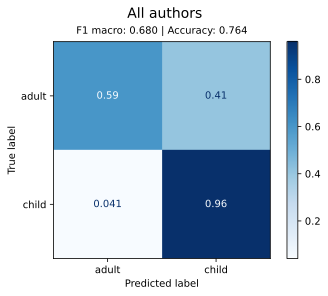

In [14]:
palette = sns.color_palette('gist_stern_r', as_cmap=True)
classes = [label for label in encoded_labels]
title = "All authors"

# Subtitle
scorers = []
for scoring, _ in gs.scorer_.items():
    score = gs.cv_results_[f'mean_test_{scoring}'].mean()
    scoring = scoring.replace('_', ' ').capitalize()
    scorers.append(f'{scoring}: {score:.3f}')

subtitle = " | ".join(scorers)

disp = ConfusionMatrixDisplay.from_estimator(
    gs,
    X_test,
    y_test,
    display_labels=classes,
    cmap=plt.cm.Blues,
    normalize='true'
)

plt.suptitle(title, y=1, fontsize=14)
disp.ax_.set_title(subtitle, fontsize=10, pad=8)
disp.ax_.tick_params(axis='x');

In [15]:
features_names = gs.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names_out()
clf = gs.best_estimator_.named_steps['linearsvc']

In [16]:
def plot_coefficients(
    classifier: Any, 
    feature_names: Any,
    *, 
    who: str = 'all', 
    n_features: int = 20,
    score: str = None
) -> None:

    coef = classifier.coef_.ravel()
    top_pos_coefficients = np.argsort(coef)[-n_features:]
    top_neg_coefficients = np.argsort(coef)[:n_features]
    top_coefficients = np.hstack([top_neg_coefficients, top_pos_coefficients])

    feature_names = np.array(feature_names)

    # Plot
    plt.figure(figsize=(n_features * 0.75, n_features * 0.25))

    # Appearance
    colors = ['#a52040' if c < 0 else '#404080' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_features), coef[top_coefficients], color=colors, zorder=2)
    plt.suptitle(f"Coefficients ({classifier.__class__.__name__})", y=.975, fontsize=14)

    # - Subtitle (main title is already set as `suptitle`)
    title = "All authors" if who == 'all' else who.title()
    plt.title(f"{title} (top {n_features * 2} features)", x=.485, pad=8)

    # - Axis labels
    _, _, ymin, ymax = plt.axis()
    step = 0.5
    # Round to nearest 0.5:
    ymin = round(ymin * 2) / 2 - step
    ymax = round(ymax * 2) / 2 + step

    plt.yticks(np.arange(ymin, ymax, step))
    plt.xticks(np.arange(0, 2 * n_features), feature_names[top_coefficients], ha='right', rotation=60)
    plt.grid(axis='both', linestyle='--', alpha=.25, zorder=1)

    # Custom legend 
    adult_patch = mpatches.Patch(color='#a52040', label='Adult')
    child_patch = mpatches.Patch(color='#404080', label='Child')
    plt.legend(handles=[adult_patch, child_patch], loc='lower right')

    # Save figure before showing it; `show()` clears the canvas
    plt.savefig(f"img/SVM/feature_importance_{n_features * 2}_svm_{who.split()[-1]}_{score:.3f}.svg")
    plt.show();

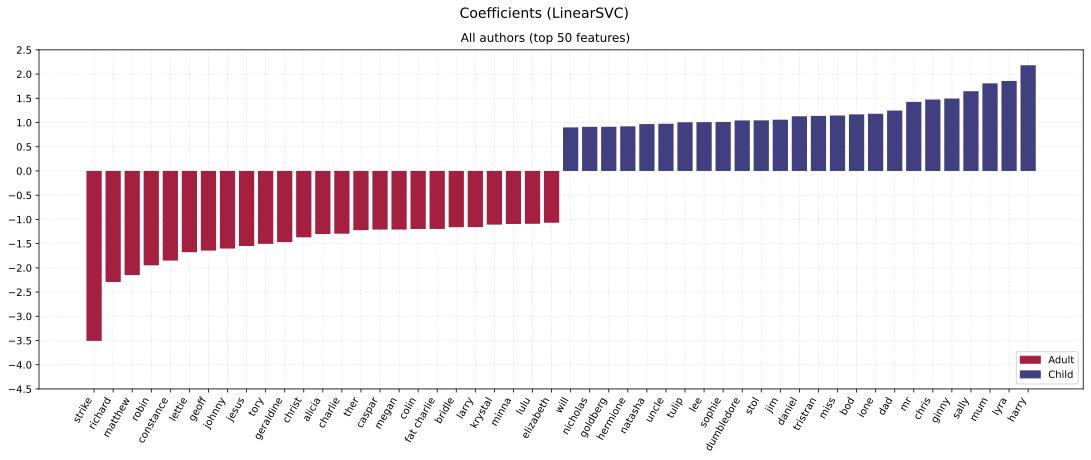

In [17]:
f1 = gs.cv_results_['mean_test_f1_macro'].mean()
plot_coefficients(clf, features_names, who='all', n_features=25, score=f1)